In [4]:
import warnings

import numpy as np
import timecorr as tc
import seaborn as sns
import os
from matplotlib import pyplot as plt
from scipy.stats import wishart
import hypertools as hyp
from scipy.spatial.distance import cdist

%matplotlib inline

SMALL_SIZE = 18
MEDIUM_SIZE = 21
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
if not os.path.isdir('figs'):
    os.mkdir('figs')
figdir = 'figs'

In [11]:
def random_corrmat(K):
    x = np.random.randn(K, K)
    x = x * x.T
    x /= np.max(np.abs(x))
    np.fill_diagonal(x, 1.)
    return x

In [24]:
def ramping_dataset(K, T):
    warnings.simplefilter('ignore')
    def dist(a, b):
        return cdist(np.atleast_2d(a), np.atleast_2d(b), 'correlation')
    
    a = tc.mat2vec(random_corrmat(K))
    b = tc.mat2vec(random_corrmat(K))
    max_dist = dist(a, b)
    max_iter = 100
    for i in np.arange(max_iter):
        next_b = tc.mat2vec(random_corrmat(K))
        next_dist = dist(a, next_b)
        if next_dist > max_dist:
            b = next_b
            max_dist = next_dist
    
    mu = np.linspace(1, 0, T)
    
    corrs = np.zeros([T, int((K**2 - K)/2 + K)])
    Y = np.zeros([T, K])
    
    for t in np.arange(T):
        corrs[t, :] = mu[t]*a + (1 - mu[t])*b
        Y[t, :] = np.random.multivariate_normal(mean=np.zeros([K]), cov=tc.vec2mat(corrs[t, :]))
    
    return Y, corrs, max_dist

In [25]:
def recovery_test(data, true_corrs, **kwargs):
    K = data.shape[1]
    recovered_corrs = tc.timecorr(data, **kwargs)
    return np.diag(1 - cdist(true_corrs, recovered_corrs, 'correlation'))    

In [34]:
def plot_ribbon(ts, xs, color='k', ribbon_alpha=0.2, ax=None):
    mean = np.mean(xs, axis=0)
    ci = 1.96 * np.divide(np.std(xs, axis=0), np.sqrt(x.shape[0]))
    
    if ax == None:
        ax = plt.gca()
    
    ax.fill_between(xvals, mean - ci, mean + ci, color=color, alpha=ribbon_alpha)
    ax.plot(ts, mean, color=color)    

In [36]:
def ramping_multi_test(K, T, N, kernels, legend=True, xlab='Time (samples)', ylab='Correlation\n(recovered vs. ground truth)'):
    true_corrs = [np.zeros([N, T])]*len(kernels)
    a_corrs = [np.zeros([N, T])]*len(kernels)
    b_corrs = [np.zeros([N, T])]*len(kernels)
    
    for n in np.arange(N):
        next_Y, next_corrs, next_dist = ramping_dataset(K, T)
        for i, k in enumerate(kernels):
            recovered_corrs = tc.timecorr(next_Y, weights_function=k['weights'], weights_params=k['params'])
            true_corrs[i][n, :] = np.diag(1 - cdist(true_corrs, recovered_corrs, 'correlation'))
            a_corrs[i][n, :] = np.diag(1 - cdist(np.tile(ramping_corrs[0, :], [T, 1]), recovered_corrs, 'correlation'))
            b_corrs[i][n, :] = np.diag(1 - cdist(np.tile(ramping_corrs[-1, :], [T, 1]), recovered_corrs, 'correlation'))
    
    colors = sns.cubehelix_palette(n_colors=len(kernels))
    fig, ax = plt.subplots(nrows=1, ncols=len(3), sharey=True)
    
    ts = np.arange(T)
    for i, k in enumerate(kernels):
        plot_ribbon(ts, true_corrs[i], color=colors[i], ax=ax[0])
        plot_ribbon(ts, a_corrs[i], color=colors[i], ax=ax[1])
        plot_ribbon(ts, b_corrs[i], color=colors[i], ax=ax[2])
    
    if not (ylab == None):
        a[0].ylabel(ylab)
    
    if not (xlab == None):
        for a in ax:        
            a.xlabel(xlab)
    
    if legend:
        a[0].legend(list(map(lambda x: x['name'], kernels)))

In [37]:
delta = {'name': '$\delta$', 'weights': tc.eye_weights, 'params': tc.eye_params}
gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': 20}}
laplace = {'name': 'Laplace', 'weights': tc.laplace_weights, 'params': {'scale': 20}}
mexican_hat = {'name': 'Mexican hat', 'weights': tc.mexican_hat_weights, 'params': {'sigma': 100}}
kernels = [delta, gaussian, laplace, mexican_hat]

ramping_multi_test(10, 100, 5, kernels)

ValueError: XA must be a 2-dimensional array.

In [28]:
#warnings.simplefilter('ignore') #ignore non pos-def warning
K = 50
T = 1000
ramping_Y, ramping_corrs, max_dist = ramping_dataset(K, T)
print(f'Distance between a and b: {float(max_dist)}')



Distance between a and b: 0.46739710231823994


In [29]:
def recovery_plots(data, true_corrs, kernels, legend=True, xlab='Time (samples)', ylab='Correlation\n(recovered vs. ground truth)'):
    T = data.shape[0]
    ts = np.arange(T)
    colors = sns.cubehelix_palette(n_colors=len(kernels))
    for i, k in enumerate(kernels):
        plt.plot(ts, recovery_test(data, true_corrs, weights_function=k['weights'], weights_params=k['params']), color=colors[i])
    
    if legend:
        plt.legend(list(map(lambda x: x['name'], kernels)))
    
    plt.ylim([0, 1])
    plt.xlim([0, T-1])
    
    if not (xlab == None):
        plt.xlabel(xlab)
    
    if not (ylab == None):
        plt.ylabel(ylab)

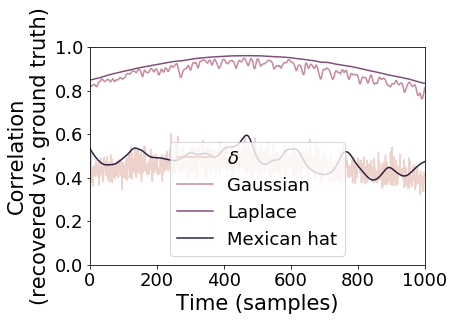

In [30]:
recovery_plots(ramping_Y, ramping_corrs, [delta, gaussian, laplace, mexican_hat])
plt.savefig(os.path.join(figdir, 'ramping_recovery_full.pdf'))

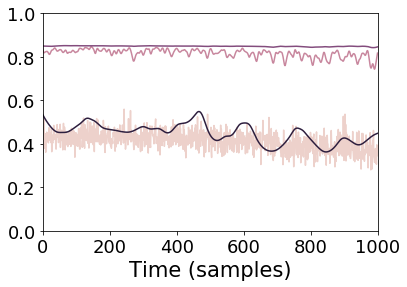

In [31]:
recovery_plots(ramping_Y, np.tile(ramping_corrs[0, :], [T, 1]), [delta, gaussian, laplace, mexican_hat], legend=False, ylab=None)
plt.savefig(os.path.join(figdir, 'ramping_recovery_a.pdf'))

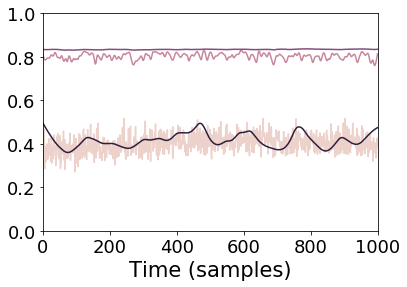

In [32]:
recovery_plots(ramping_Y, np.tile(ramping_corrs[-1, :], [T, 1]), [delta, gaussian, laplace, mexican_hat], legend=False, ylab=None)
plt.savefig(os.path.join(figdir, 'ramping_recovery_b.pdf'))